In [1]:
%config IPCompleter.greedy=True
%matplotlib inline


import torch
import os
from torch.jit import script, trace
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import csv
import random
import re
import itertools
import math
import pandas as pd
import unicodedata
import codecs
import itertools



import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import numpy as np


In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

CUDA = torch.cuda.is_available()
# device = torch.device("cuda" if CUDA else "cpu")
device = torch.device("cuda")

# DATA


leave out validation set

In [3]:
INPUT_SIZE = 2500


xy = pd.read_csv('./prep_student_input.csv')
z = pd.read_csv('./word_translations.csv')

translations = {z['Italian'][i]: z['English'][i] for i in range(len(z))}


# pastconvo = [xy['Prep'][randomindexes[i]]+' '+xy['Obj'][randomindexes[i]] +' '+ xy['Color'][randomindexes[i]] +' '+ xy['Past Convo'][randomindexes[i]] for i in range(len(randomindexes))]
pastconvo = [xy['Past Convo'][i] for i in range(len(xy))]

response = [xy['Tutor Response'][i] for i in range(len(xy))]


#' '.join(pastconvo[i].split()[TOKENS_TAKEN:])
pairs = [[pastconvo[i], response[i]] for i in range(len(pastconvo))]

print("input data selected")

input data selected


# VOCABUOLARY


In [4]:
# Default word tokens
PAD_token = 0  # Used for padding short sentences
SOS_token = 1  # Start-of-sentence token
EOS_token = 2  # End-of-sentence token

class Vocabulary:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3  # Count SOS, EOS, PAD

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.num_words
            self.word2count[word] = 1
            self.index2word[self.num_words] = word
            self.num_words += 1
        else:
            self.word2count[word] += 1

    # Remove words below a certain count threshold # CHANGE probably shouldn't do this
    def trim(self, min_count):
        keep_words = []
        for k, v in self.word2count.items():
            if v >= min_count:
                keep_words.append(k)        
        print('keep_words {} / {} = {:.4f}'.format(
            len(keep_words), len(self.word2index), len(keep_words) / len(self.word2index)
        ))
        # Reinitialize dictionaries
        self.word2index = {}
        self.word2count = {}
        self.index2word = {PAD_token: "PAD", SOS_token: "SOS", EOS_token: "EOS"}
        self.num_words = 3 # Count default tokens

        for word in keep_words:
            self.addWord(word)

In [5]:
# make data simple
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

In [6]:
# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    s = re.sub(r"\s+", r" ", s).strip()
    return s

# creating vocab


In [7]:
pairs = [[normalizeString(line) for line in p] for p in pairs]
random.shuffle(pairs)

pastconvo = [p[0] for p in pairs]
response = [p[1] for p in pairs]


voc = Vocabulary("dialog")

#getting  rid of rare words
for pair in pairs:
    voc.addSentence(pair[0])
    voc.addSentence(pair[1])
print("counted words:", voc.num_words)
print("vocabulary created")


counted words: 1014
vocabulary created


# prepare data

In [8]:
def indexesFromSentence(voc, sentence):
    return [voc.word2index[word] for word in sentence.split(' ')] + [EOS_token]


In [9]:
#make column consistent and transpose
def zeroPadding(l, fillvalue= 0):
    return list(itertools.zip_longest(*l, fillvalue=fillvalue))

In [10]:
def binaryMatrix(l, value=0):
    m = []
    for i, seq in enumerate(l):
        m.append([])
        for token in seq:
            if token == PAD_token:
                m[i].append(0)
            else:
                m[i].append(1)
    return m

In [11]:
def inputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    padVar = torch.LongTensor(padList)
    return padVar, lengths

# Returns padded target sequence tensor, padding mask, and max target length
def outputVar(l, voc):
    indexes_batch = [indexesFromSentence(voc, sentence) for sentence in l]
    max_target_len = max([len(indexes) for indexes in indexes_batch])
    padList = zeroPadding(indexes_batch)
    mask = binaryMatrix(padList)
    mask = torch.ByteTensor(mask)
    padVar = torch.LongTensor(padList)
    return padVar, mask, max_target_len

# Returns all items for a given batch of pairs
def batch2TrainData(voc, pair_batch):
    pair_batch.sort(key=lambda x: len(x[0].split(" ")), reverse=True)
    input_batch, output_batch = [], []
    for pair in pair_batch:
        input_batch.append(pair[0])
        
        output_batch.append(pair[1])
    inp, lengths = inputVar(input_batch, voc)
    output, mask, max_target_len = outputVar(output_batch, voc)
    return inp, lengths, output, mask, max_target_len, input_batch, output_batch

# MODEL

In [12]:
class EncoderRNN(nn.Module):
    def __init__(self, hidden_size, embedding, n_layers=1, dropout=0):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.embedding = embedding

        # Initialize GRU; the input_size and hidden_size params are both set to 'hidden_size'
        #   because our input size is a word embedding with number of features == hidden_size
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers,
                          dropout=(0 if n_layers == 1 else dropout), bidirectional=True)

    def forward(self, input_seq, input_lengths, hidden=None):
        # Convert word indexes to embeddings
        embedded = self.embedding(input_seq)
        # Pack padded batch of sequences for RNN module
        packed = nn.utils.rnn.pack_padded_sequence(embedded, input_lengths)
        # Forward pass through GRU
        outputs, hidden = self.gru(packed, hidden)
        # Unpack padding
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs)
        # Sum bidirectional GRU outputs
        outputs = outputs[:, :, :self.hidden_size] + outputs[:, : ,self.hidden_size:]
        # Return output and final hidden state
        return outputs, hidden

Attention using dot

In [13]:
# Luong attention layer
class Attn(nn.Module):
    def __init__(self, method, hidden_size):
        super(Attn, self).__init__()
        self.method = method
        if self.method not in ['dot', 'general', 'concat']:
            raise ValueError(self.method, "is not an appropriate attention method.")
        self.hidden_size = hidden_size
        if self.method == 'general':
            self.attn = nn.Linear(self.hidden_size, hidden_size)
        elif self.method == 'concat':
            self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
            self.v = nn.Parameter(torch.FloatTensor(hidden_size))

    def dot_score(self, hidden, encoder_output):
        return torch.sum(hidden * encoder_output, dim=2)
    
    def general_score(self, hidden, encoder_output):
        energy = self.attn(encoder_output)
        return torch.sum(hidden * energy, dim=2)

    def concat_score(self, hidden, encoder_output):
        energy = self.attn(torch.cat((hidden.expand(encoder_output.size(0), -1, -1), encoder_output), 2)).tanh()
        return torch.sum(self.v * energy, dim=2)

    def forward(self, hidden, encoder_outputs):
        # Calculate the attention weights (energies) based on the given method
        if self.method == 'general':
            attn_energies = self.general_score(hidden, encoder_outputs)
        elif self.method == 'concat':
            attn_energies = self.concat_score(hidden, encoder_outputs)
        elif self.method == 'dot':
            attn_energies = self.dot_score(hidden, encoder_outputs)

        # Transpose max_length and batch_size dimensions
        attn_energies = attn_energies.t()

        # Return the softmax normalized probability scores (with added dimension)
        return F.softmax(attn_energies, dim=1).unsqueeze(1)

In [14]:
class LuongAttnDecoderRNN(nn.Module):
    def __init__(self, attn_model, embedding, hidden_size, output_size, n_layers=1, dropout=0.1):
        super(LuongAttnDecoderRNN, self).__init__()

        # Keep for reference
        self.attn_model = attn_model
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout = dropout

        # Define layers
        self.embedding = embedding
        self.embedding_dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, dropout=(0 if n_layers == 1 else dropout))
        self.concat = nn.Linear(hidden_size * 2, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

        self.attn = Attn(attn_model, hidden_size)
        
    def forward(self, input_step, last_hidden, encoder_outputs):
        # Note: we run this one step (word) at a time
        # Get embedding of current input word
        embedded = self.embedding(input_step)
        embedded = self.embedding_dropout(embedded)
        # Forward through unidirectional GRU
        rnn_output, hidden = self.gru(embedded, last_hidden)
        # Calculate attention weights from the current GRU output
        attn_weights = self.attn(rnn_output, encoder_outputs)
        # Multiply attention weights to encoder outputs to get new "weighted sum" context vector
        context = attn_weights.bmm(encoder_outputs.transpose(0, 1))
        # Concatenate weighted context vector and GRU output using Luong eq. 5
        rnn_output = rnn_output.squeeze(0)
        context = context.squeeze(1)
        concat_input = torch.cat((rnn_output, context), 1)
        concat_output = torch.tanh(self.concat(concat_input))
        # Predict next word using Luong eq. 6
        output = self.out(concat_output)
        output = F.softmax(output, dim=1)
        # Return output and final hidden state
        return output, hidden

# EVAL

In [15]:
class GreedySearchDecoder(nn.Module):
    def __init__(self, encoder, decoder):
        super(GreedySearchDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, input_seq, input_length, max_length):
        # Forward input through encoder model
        encoder_outputs, encoder_hidden = self.encoder(input_seq, input_length)
        # Prepare encoder's final hidden layer to be first hidden input to the decoder
        decoder_hidden = encoder_hidden[:decoder.n_layers]
        # Initialize decoder input with SOS_token
        decoder_input = torch.ones(1, 1, device=device, dtype=torch.long) * SOS_token
        # Initialize tensors to append decoded words to
        all_tokens = torch.zeros([0], device=device, dtype=torch.long)
        all_scores = torch.zeros([0], device=device)
        # Iteratively decode one word token at a time
        for _ in range(max_length):
            # Forward pass through decoder
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden, encoder_outputs)
            # Obtain most likely word token and its softmax score
            decoder_scores, decoder_input = torch.max(decoder_output, dim=1)
            # Record token and score
            all_tokens = torch.cat((all_tokens, decoder_input), dim=0)
            all_scores = torch.cat((all_scores, decoder_scores), dim=0)
            # Prepare current token to be next decoder input (add a dimension)
            decoder_input = torch.unsqueeze(decoder_input, 0)
        # Return collections of word tokens and scores
        return all_tokens, all_scores
    

In [16]:
def evaluate(encoder, decoder, searcher, voc, sentence, max_length):
    ### Format input sentence as a batch
    # words -> indexes
    indexes_batch = [indexesFromSentence(voc, sentence)]
    # Create lengths tensor
    lengths = torch.tensor([len(indexes) for indexes in indexes_batch])
    # Transpose dimensions of batch to match models' expectations
    input_batch = torch.LongTensor(indexes_batch).transpose(0, 1)
    # Use appropriate device
    input_batch = input_batch.to(device)
    lengths = lengths.to(device)
    # Decode sentence with searcher
    tokens, scores = searcher(input_batch, lengths, max_length)
    # indexes -> words
    decoded_words = [voc.index2word[token.item()] for token in tokens]
    return decoded_words, scores


#returns a list of output words fiven a input sentence
def evaluateInput(encoder, decoder, searcher, voc, input_sentence, max_length):
    input_sentence = normalizeString(input_sentence)
    # Evaluate sentence
    output_words, scores = evaluate(encoder, decoder, searcher, voc, input_sentence, max_length)
    # Format and print response sentence
    output_words[:] = [x for x in output_words if not (x == 'EOS' or x == 'PAD')]
    return output_words, scores
#     print('Bot:', ' '.join(output_words))

def evaluate_with_target(encoder, decoder, searcher, voc, TEST_SIZE, INPUT_SIZE):

    randomindexes = [random.randint(INPUT_SIZE, len(xy['Past Convo'])) for _ in range(TEST_SIZE)]

    inputs = [xy['Past Convo'][randomindexes[i]] for i in range(TEST_SIZE)]
    targets = [xy['Tutor Response'][randomindexes[i]] for i in range(TEST_SIZE)]

    for i in range(TEST_SIZE):
        max_length = len(normalizeString(targets[i]).split()) 
        print("past convo:", inputs[i])
        print("\n")

        output_words, scores = evaluateInput(encoder, decoder, searcher, voc, inputs[i], max_target_len)
        print('Bot:', ' '.join(output_words))
        print("\n")
        print("Correct: ", targets[i])
        print("\n")
        
def validation_eval(encoder, decoder, searcher, voc, TEST_SIZE, INPUT_SIZE):

    randomindexes = [random.randint(INPUT_SIZE, len(xy['Past Convo'])) for _ in range(TEST_SIZE)]

    inputs = [xy['Past Convo'][randomindexes[i]] for i in range(TEST_SIZE)]
    targets = [xy['Tutor Response'][randomindexes[i]] for i in range(TEST_SIZE)]
    
    scores = []  
    for i in range(TEST_SIZE):
        max_length = len(normalizeString(targets[i]).split()) 
        print("past convo:", inputs[i])
        print("\n")

        output_words, scorelist = evaluateInput(encoder, decoder, searcher, voc, inputs[i], max_target_len)
        scores.append(sum(scorelist)/len(scorelist))
        print('Bot:', ' '.join(output_words))
        print("\n")
        
    return sum(scores)/len(scores)


# simulated student

In [17]:
import  pprint
pp = pprint.PrettyPrinter(indent = 4)


z = pd.read_csv('./word_translations.csv')
translations = {z['Italian'][i]: z['English'][i] for i in range(len(z))}
translations_toItalian = {z['English'][i]: z['Italian'][i] for i in range(len(z))}

concepts = list(translations.keys())
prep = concepts[:8]
color = concepts[8:16]
obj = concepts[16:]

def concept(word):
    if iseng(word):
        return translations_toItalian[word]
    else:
        return word

def iseng(word):
    if word in translations_toItalian.keys():
        return True
    else:
        return False

def isitalian(word):
    if word in translations.keys():
        return True
    else:
        return False

#guess is list in correct order, correct is solution list
def identify_incorrects(guess, correct):
    rv = []
    for i in range(len(correct)):
        if guess[i] != correct[i]:
            rv.append(correct[i])
    return rv
        
    

In [18]:

#correct order is prep obj color


class Student:
    def __init__(self, pickup, forget):
        global prep,color,obj
        self.pickup = pickup
        self.forget = forget
        self.knowledge = {
            "prep": {p: random.random() for p in prep},
            "color": {c: random.random() for c in color},
            "obj": {o: random.random() for o in obj}
        }
       
    #TODO: can output random italian word too
    #output three words in correct order list
    def guess(self, correct):
        global translations
        #correct: [prep, object, color]
        prep_c, obj_c, color_c = correct
        prep_t = translations[prep_c]
        obj_t = translations[obj_c]
        color_t = translations[color_c]
        
#         rv = 'is it '
        rv = []
        rv.append(prep_c) if self.knowledge["prep"][prep_c] > 0.7 else rv.append(prep_t)
        rv.append(obj_c)  if self.knowledge["obj"][obj_c] > 0.7 else rv.append(obj_t)
        rv.append(color_c) if self.knowledge["color"][color_c] > 0.7 else rv.append(color_t)
        return rv
    
    #returns empty string if nothing to ask
    #returns the eng word
    def ask(self, correct):
        #TODO: randomize order
        #correct = [prep_c, obj_c, color_c]
        global translations
        word = ''
        prep_c, obj_c, color_c = correct
        
        if self.knowledge["prep"][prep_c] < 0.3:
            word = prep_c
        elif self.knowledge["obj"][obj_c] <  0.3:
            word = obj_c
        elif self.knowledge["color"][color_c] < 0.3:
            word = color_c
        
        if word != '':
            #rv = 'How do i say ' + translations[word] + ' in Italian'
            rv = translations[word]
        else:
            rv = ''
        return rv
    #forgets concepts that is not mentioned for each tutor response, excluding  gained
#     def forget(self, gained):
        
    def pickout_concepts(self, output_words):
        #return all concepts (only in italian)
        rv = []
        for word in output_words:
            if isitalian(word):
                rv.append(word)
            elif iseng(word):
                rv.append(concept(word))
        return list(set(rv))
    
    def pickout_relevent_concepts(self, output_words, correct):
        #all concepts in italian
        concepts = self.pickout_concepts(output_words)
        return [x for x in concepts if x in correct]
                
    def change_knowledge(self, output_words, correct):
        #pick out knowledge
        global prep,color,obj
        concepts = self.pickout_relevent_concepts(output_words, correct)
        p = []
        o = []
        c=  []
        for word in concepts:
            if word in prep:
                p.append(word)
            elif word in color:
                c.append(word)
            elif word in obj:
                o.append(word)
        order = ["prep", "obj", "color"]  
        groups = [p, o, c]
        change = 0
        
        #update knowledge and return change
        #TODO only forget things that are not mentioned 
        for i in range(3):
            for c in groups[i]:
                if self.knowledge[order[i]][c] < 1:
                    self.knowledge[order[i]][c] = 1
                    change +=1
#                     if random.random() < self.pickup: 
#                         self.knowledge[order[i]][c] = min(self.knowledge[order[i]][c]+0.4, 1)
#                         change += 1   

        return change




In [19]:

def penalty(output_words, student, studentexpect, correct, incorrects):
    concepts = student.pickout_concepts(output_words)
    relevent = student.pickout_relevent_concepts(output_words, correct)
    #TODO relevent includes english and italian
    
    #if nothing correct but confirmed could be because ordering or grammar
    
    #conditional on student answer
    # 1 => penalize
    # 0 => reward
    
    #incorrect = list incorrect concepts in italian
    if len(incorrects) == 0 and studentexpect == '':
        if 'correct' not in output_words or 'yes' not in output_words:
#             print("penalize: student was correct but no confirmation")
            return 1
        else:
#             print("reward: correct")
            return 0.2
    elif studentexpect != '':
        #TODO need both eng and italian 
        if studentexpect in relevent:
#             print("reward: answered question")
            return 0.2
        else:
#             print("penalize: didn't answer question")
            return 1
    else:
        #the student made a guess that's incorrect 
        if len(incorrects) == 3 and 'correct' in output_words:
#             print("penalize: all wrong but said correct")
            return 1
        if concepts == []:
            #maybe made a grammar hint
#             print("neutral: did not make a word hint")
            return 0.8
        elif len(concepts) != len(relevent):
#             print("penalize: had irrelevent hints")
            return 1
        else:
            #needs to be a hint that student got incorrect
            for hint in relevent:
                if hint not in incorrects:
#                     print("penalize: not a hint that student got wrong")
                    return 1
#             print("reward: is a hint student got wrong")
            return 0.2
        
    
    
    

In [20]:

# start one eval
def simulate_with_student(encoder, decoder, searcher, voc):
# one conversation
    student = Student(1,0)
    tutor_score = 0
    studentexpect = ''
    guess_incorrects = []
    prep_c =  random.choice(prep)
    color_c = random.choice(color)
    obj_c = random.choice(obj)
    correct = [prep_c, obj_c, color_c]
#     print(correct)
    
    #TODO: while student not correct or expects answer
    for i in range(10):
        coin = random.random()
        if coin < 0.5 and student.ask(correct) != '':
            askeng = student.ask(correct)
            studentexpect = translations_toItalian[askeng]
            input_sent = 'How do you say ' + askeng + ' in Italian'
        else:
            guess = student.guess(correct)
            guess_incorrects = identify_incorrects(guess, correct)
            input_sent = "is it "+ guess[0] + " " + guess[1] + " " + guess[2]
        
#         print('\n')
#         print('Student:', input_sent)
#         print('incorrect:', guess_incorrects)
#         print('expect:', studentexpect)

        #evaluate on model
        output_words,scores = evaluateInput(encoder, decoder, searcher, voc, input_sent, max_target_len)
        output = ' '.join(output_words)
        #evaluate on input
#         output = input('> ')
#         if output == 'q' or output == 'quit': break
#         output_words = output.split()
        
        #how many concpets changed
        change = student.change_knowledge(output_words, correct)
        
        #change tutor score
        tutor_score += penalty(output_words, student, studentexpect, correct, guess_incorrects)

#         print('Bot:', output)
#         print('pickout concpets:', student.pickout_concepts(output_words))
#         print('change:', change)
        #TODO: tutor_score
#         print('penalty', tutor_score)  
        studentexpect = ''
        guess_incorrects = []
        
    return tutor_score
    
    

# test train with input

In [21]:

#simulate_with_student(encoder, decoder, searcher, voc)
# simulate_with_student(voc)

# TRAIN

In [22]:
# negative log lokelihood loss
# maskNLLLoss(decoder_output, target_variable[t], mask[t])
def maskNLLLoss(inp, target, mask): 
    nTotal = mask.sum()
    crossEntropy = -torch.log(torch.gather(inp, 1, target.view(-1, 1)).squeeze(1))
    loss = crossEntropy.masked_select(mask).mean()
    #loss = reward * loss -> 0.001/1
#     loss = loss * tutor_score
    loss = loss.to(device)
    return loss, nTotal.item()


In [23]:
def train(input_variable, lengths, target_variable, mask, max_target_len, encoder, decoder, embedding, encoder_optimizer, decoder_optimizer, batch_size, clip, iteration):
    
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_variable = input_variable.to(device)
    lengths = lengths.to(device)
    target_variable = target_variable.to(device)
    mask = mask.to(device)

    loss = 0
    print_losses = []
    n_totals = 0
    tutor_score  = 10;

    encoder_outputs, encoder_hidden = encoder(input_variable, lengths)
#     print("encoder output shape", encoder_outputs.shape)
#     print("last encoder hidden shape", encoder_hidden.shape)

    decoder_input = torch.LongTensor([[SOS_token for _ in range (small_batch_size)]])
    decoder_input = decoder_input.to(device)
#     print("initial decoder input shape", decoder_input.shape)
#     print(decoder_input)

    decoder_hidden =  encoder_hidden[:decoder.n_layers]
#     print("initial decoder hidden state shape", decoder_hidden.shape)
    for t in range(max_target_len):
        decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_outputs)

        #teacher forcing
        decoder_input = target_variable[t].view(1,-1)

        mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
        loss += mask_loss
        print_losses.append(mask_loss.item() * nTotal)

        n_totals += nTotal
        
    returned_loss = sum(print_losses) / n_totals
    
    #student simulation
#     if iteration > 200:
#         encoder.eval()
#         decoder.eval()

#         searcher = GreedySearchDecoder(encoder, decoder)
#         tutor_score = simulate_with_student(encoder, decoder, searcher, voc)
#         encoder.train()
#         decoder.train()

#         loss = loss * tutor_score / 10
#         returned_loss = sum(print_losses) / n_totals * tutor_score / 10

    
    loss.backward()

    # Clip gradients: gradients are modified in place
    _ = nn.utils.clip_grad_norm_(encoder.parameters(), clip)
    _ = nn.utils.clip_grad_norm_(decoder.parameters(), clip)

    # Adjust model weights
    encoder_optimizer.step()
    decoder_optimizer.step()
    
#     print("training loss", returned_loss)
# #     print(returned_losses)
#     print("\n")

    return returned_loss, tutor_score

In [ ]:
def valid(input_variable, lengths, target_variable, mask, max_target_len, encoder, decoder, embedding,
          encoder_optimizer, decoder_optimizer, batch_size, clip, VALID_SIZE):
    
    input_variable = input_variable.to(device)
    lengths = lengths.to(device)
    target_variable = target_variable.to(device)
    mask = mask.to(device)

    loss = 0
    print_losses = []
    n_totals = 0

    encoder_outputs, encoder_hidden = encoder(input_variable, lengths)
#     print("encoder output shape", encoder_outputs.shape)
#     print("last encoder hidden shape", encoder_hidden.shape)

    decoder_input = torch.LongTensor([[SOS_token for _ in range (VALID_SIZE)]])
    decoder_input = decoder_input.to(device)
#     print("initial decoder input shape", decoder_input.shape)
#     print(decoder_input)

    decoder_hidden =  encoder_hidden[:decoder.n_layers]
#     print("initial decoder hidden state shape", decoder_hidden.shape)
    for t in range(max_target_len):
        decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_outputs)

        #teacher forcing
        decoder_input = target_variable[t].view(1,-1)

        mask_loss, nTotal = maskNLLLoss(decoder_output, target_variable[t], mask[t])
        loss += mask_loss
        print_losses.append(mask_loss.item() * nTotal)

        n_totals += nTotal
    returned_loss = sum(print_losses) / n_totals
    
#     print("validation loss", returned_loss)
# #     print(returned_losses)
#     print("\n")

    return returned_loss

In [31]:
def trainIters(voc, pairs, hidden_size, dropout, attn_model, LEARN_RATE, WEIGHT_DECAY, encoder_n_layers, decoder_n_layers, n_iteration, small_batch_size, clip, INPUT_SIZE):
    
    random.shuffle(pairs)

    pastconvo = [p[0] for p in pairs]
    response = [p[1] for p in pairs]
    
    embedding = nn.Embedding(voc.num_words, hidden_size)

    encoder = EncoderRNN(hidden_size, embedding, encoder_n_layers, dropout)
    decoder = LuongAttnDecoderRNN(attn_model,  embedding, hidden_size, voc.num_words, decoder_n_layers, dropout)
    #pass models to device 
    encoder = encoder.to(device)
    decoder = decoder.to(device)

    encoder.train()
    decoder.train()

    #optimizers
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=LEARN_RATE, weight_decay=WEIGHT_DECAY)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=LEARN_RATE, weight_decay=WEIGHT_DECAY)
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    # start training
    print("START TRAINING")
    print("\n")

    returned_losses = []
    validation_losses = []
    tutor_scores = []
    searcher = GreedySearchDecoder(encoder, decoder)
    best_valid_loss = 1000000
    
    valid_loss = 7

    #predefine eval set
    # randomindexes = [random.randint(INPUT_SIZE, len(pastconvo)) for _ in range(TEST_SIZE)]
    # evalset = [pairs[randomindexes[i]] for i in range(len(randomindexes))]
    VALID_SIZE = len(pairs)-INPUT_SIZE-1

    iteration = 0
    # for iteration in range(num_iters):
    while iteration < n_iteration:
        iteration += 1
#         print(" Iteration:", iteration)

        randomindexes = [random.randint(0, INPUT_SIZE) for _ in range(small_batch_size)]
        trainset = [pairs[randomindexes[i]] for i in range(small_batch_size)]

        batches = batch2TrainData(voc, trainset)
        input_variable, lengths, target_variable, mask, max_target_len, input_batch, output_batch = batches

        #train one iter

        returned_loss, tutor_score = train(input_variable, lengths, target_variable, mask, max_target_len, encoder, decoder, embedding, encoder_optimizer, decoder_optimizer, small_batch_size, clip,iteration)

        returned_losses.append(returned_loss)
        tutor_scores.append(tutor_score)
    #     print(returned_losses)

#         print("\n")

        if iteration % 20 == 0:
            encoder.eval()
            decoder.eval()

            evalset = [pairs[i] for i in range(INPUT_SIZE, len(pairs)-1)]

            evalbatches = batch2TrainData(voc, evalset)
            input_variable, lengths, target_variable, mask, max_target_len, input_batch, output_batch = evalbatches

            valid_loss = valid(input_variable, lengths, target_variable, mask, max_target_len, encoder,
                         decoder, embedding, encoder_optimizer, decoder_optimizer, VALID_SIZE, clip, VALID_SIZE)
            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
                
            encoder.train()
            decoder.train()
        
        #stop training if validation loss stops decreasing
        if len(validation_losses) > 1000 and valid_loss > validation_losses[-60] + 0.1:
            break;
        
        validation_losses.append(valid_loss)
        

        if iteration % 400 == 0:   
            plt.plot(returned_losses, color='blue')
            plt.plot(validation_losses, color='red')
#             plt.plot(tutor_scores, color='green')
            plt.show()
    
    return best_valid_loss
    



hidden dropout attn leaning weight layers batchsize (128, 0.1, 'dot', 0.001, 0.1, 2, 2, 8)
START TRAINING




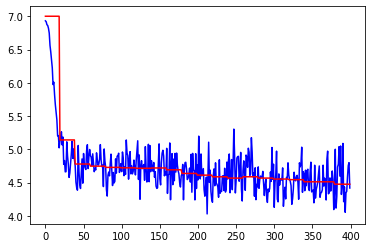

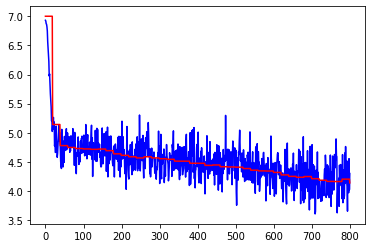

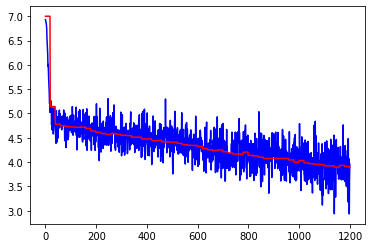

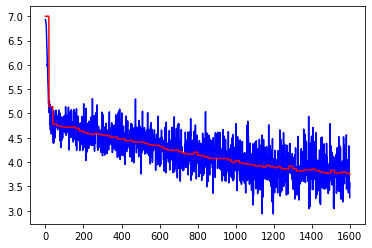

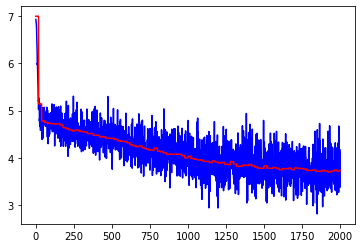

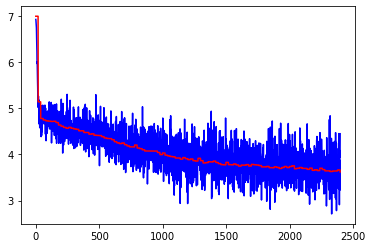

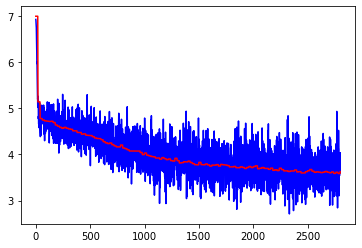

3.5869215494000417


hidden dropout attn leaning weight layers batchsize (128, 0.1, 'dot', 0.001, 0.1, 2, 2, 16)
START TRAINING




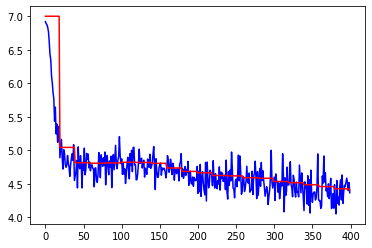

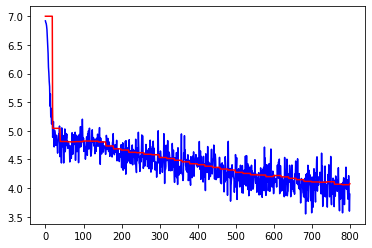

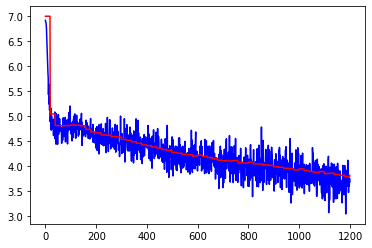

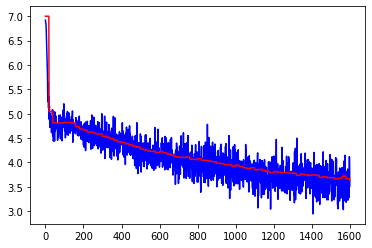

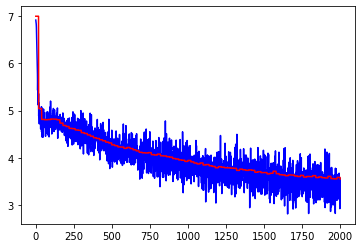

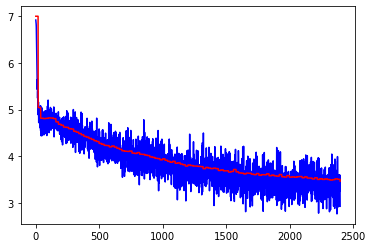

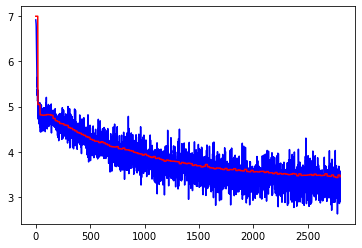

3.4279052508243604


hidden dropout attn leaning weight layers batchsize (128, 0.1, 'dot', 0.001, 0.1, 2, 2, 32)
START TRAINING




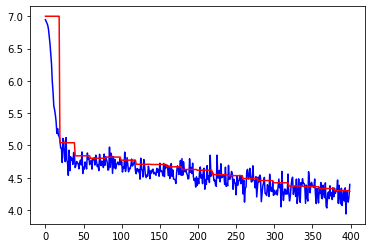

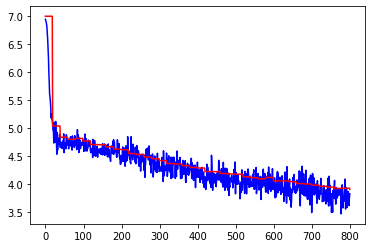

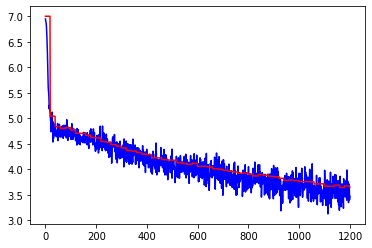

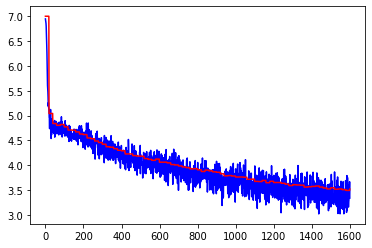

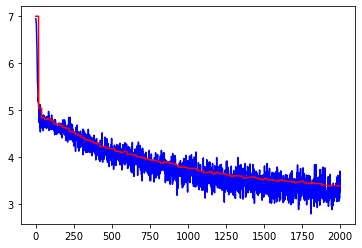

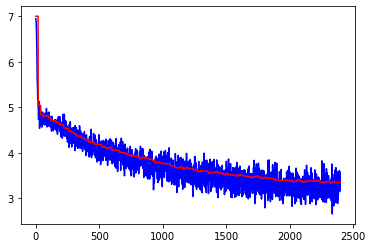

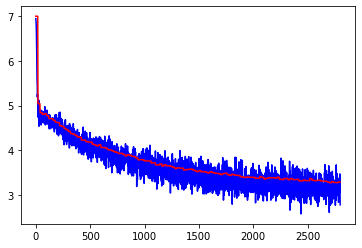

3.273109014527429


hidden dropout attn leaning weight layers batchsize (128, 0.1, 'dot', 0.001, 0.001, 2, 2, 8)
START TRAINING




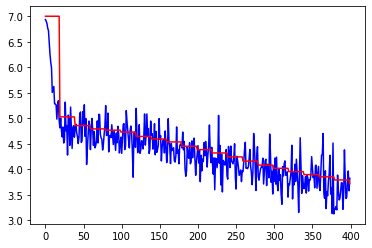

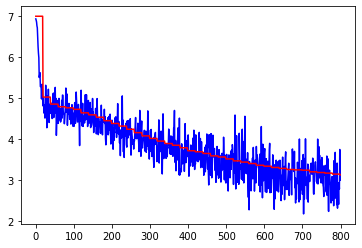

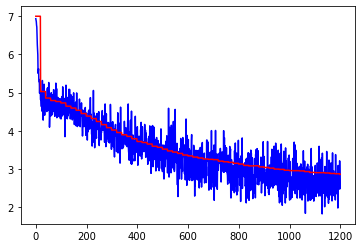

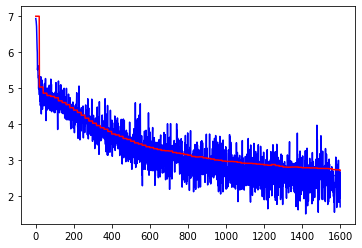

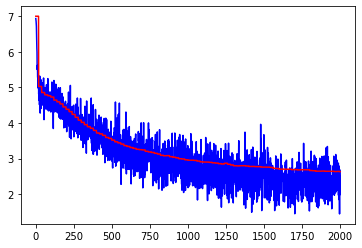

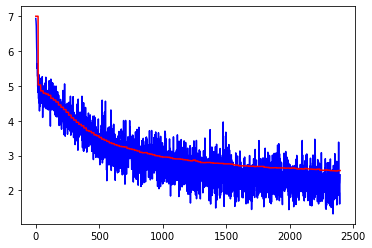

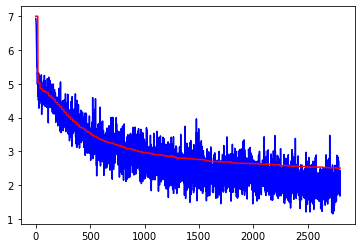

2.492745950039225


hidden dropout attn leaning weight layers batchsize (128, 0.1, 'dot', 0.001, 0.001, 2, 2, 16)
START TRAINING




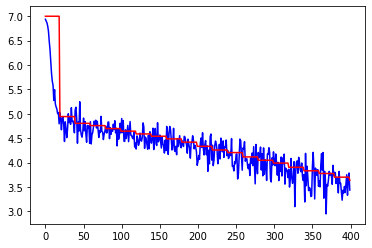

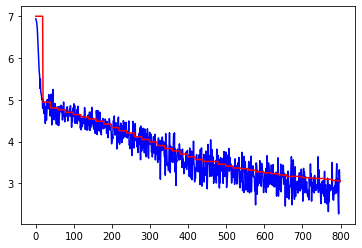

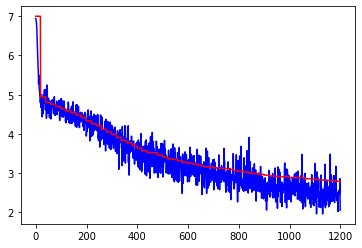

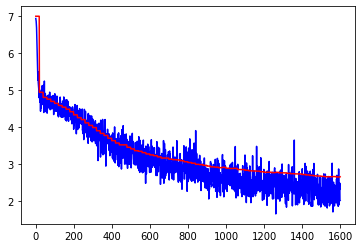

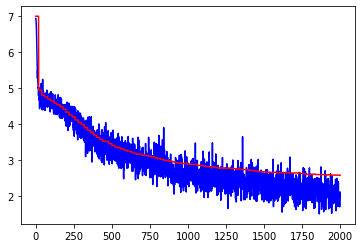

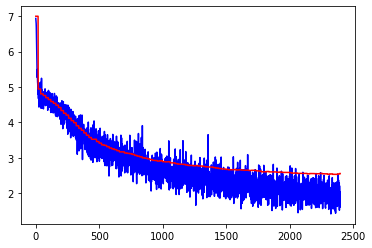

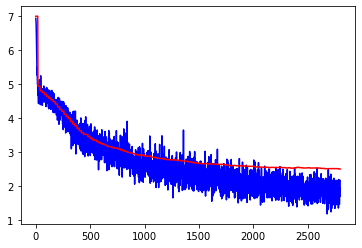

2.5065832358839986


hidden dropout attn leaning weight layers batchsize (128, 0.1, 'dot', 0.001, 0.001, 2, 2, 32)
START TRAINING




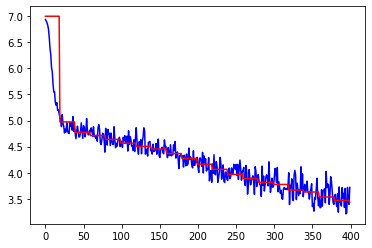

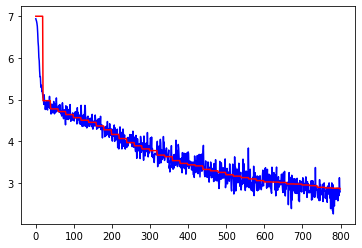

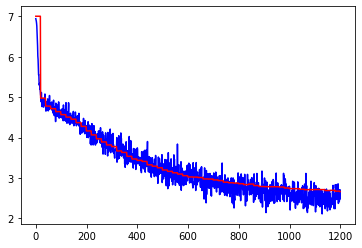

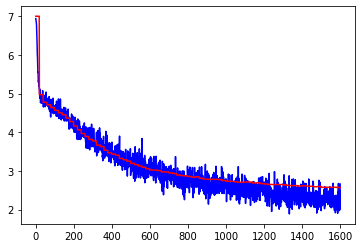

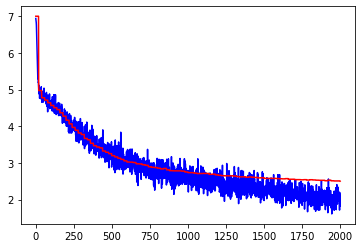

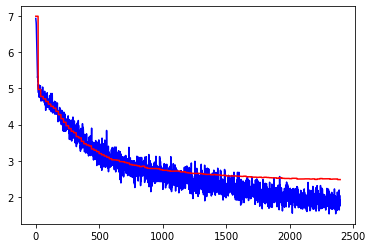

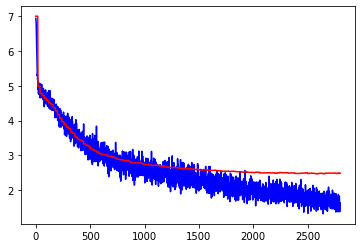

2.467397005893163


hidden dropout attn leaning weight layers batchsize (256, 0.1, 'dot', 0.001, 0.1, 2, 2, 8)
START TRAINING




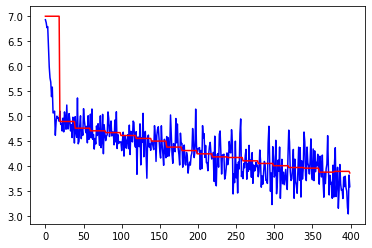

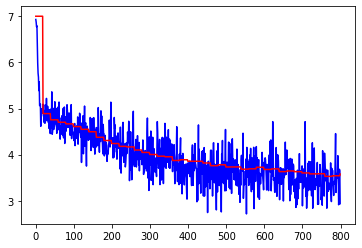

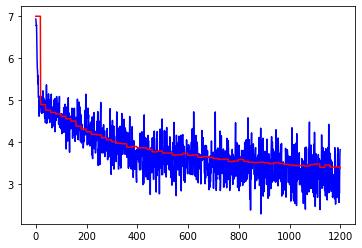

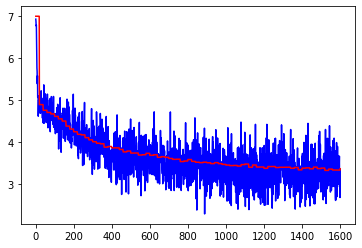

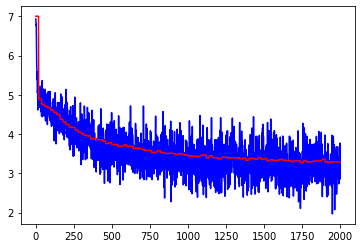

3.2368661363080102


hidden dropout attn leaning weight layers batchsize (256, 0.1, 'dot', 0.001, 0.1, 2, 2, 16)
START TRAINING




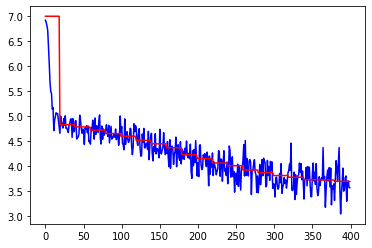

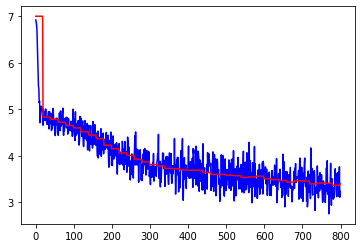

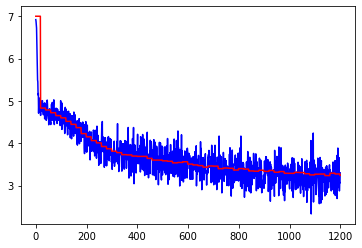

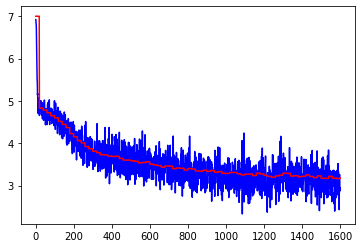

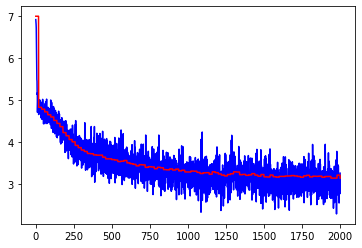

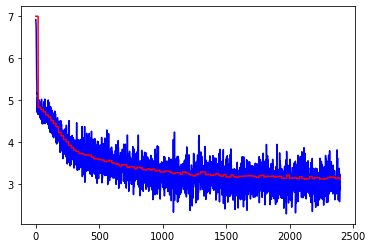

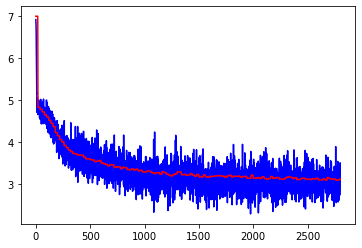

3.0913991433243853


hidden dropout attn leaning weight layers batchsize (256, 0.1, 'dot', 0.001, 0.1, 2, 2, 32)
START TRAINING




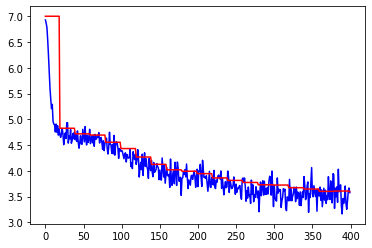

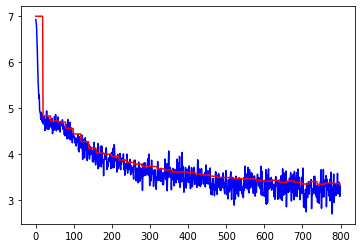

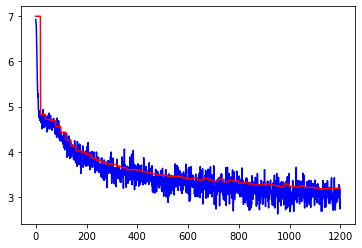

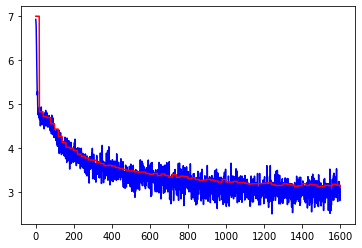

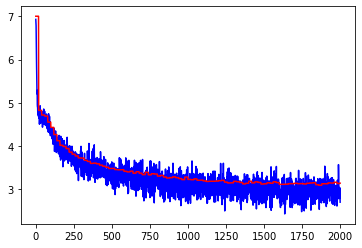

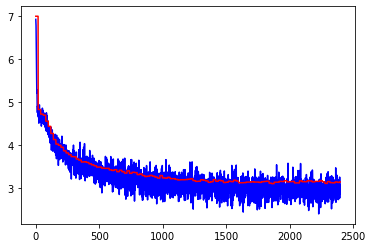

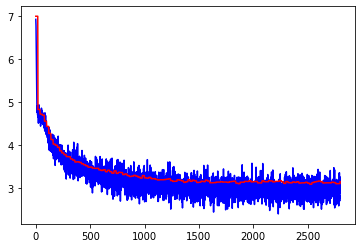

3.0840378045464933


hidden dropout attn leaning weight layers batchsize (256, 0.1, 'dot', 0.001, 0.001, 2, 2, 8)
START TRAINING




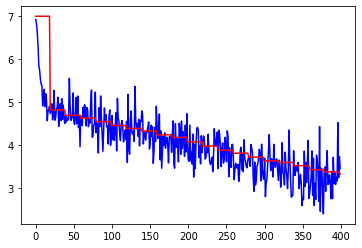

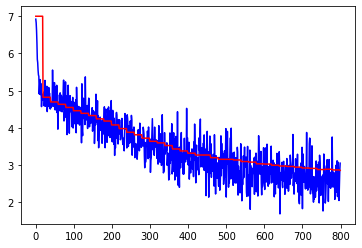

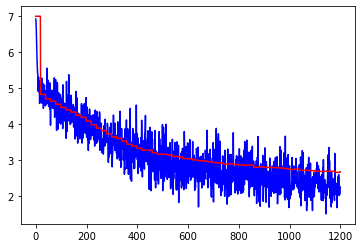

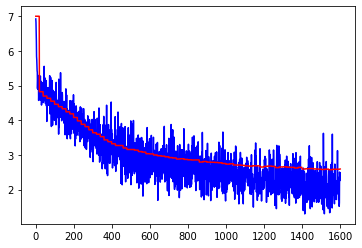

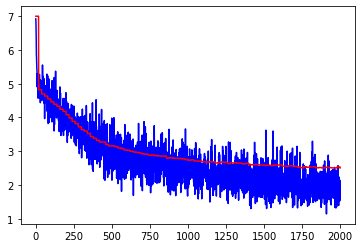

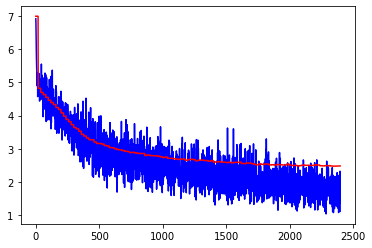

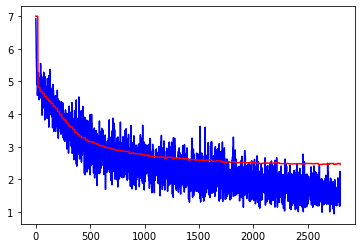

2.4557556122084065


hidden dropout attn leaning weight layers batchsize (256, 0.1, 'dot', 0.001, 0.001, 2, 2, 16)
START TRAINING




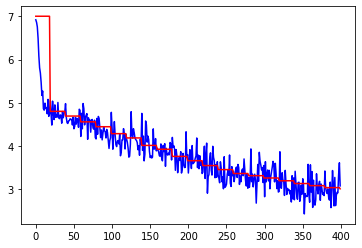

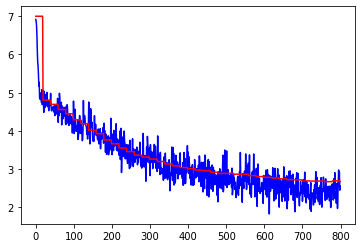

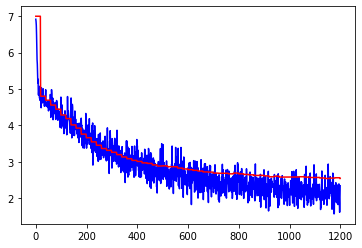

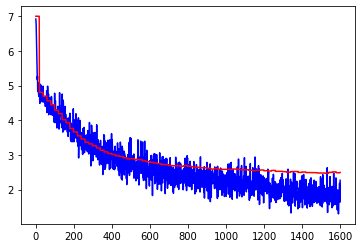

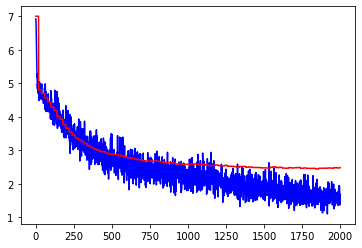

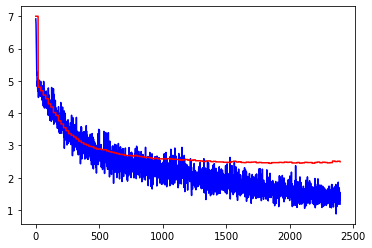

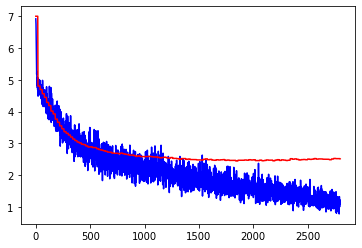

2.4463246061314456


hidden dropout attn leaning weight layers batchsize (256, 0.1, 'dot', 0.001, 0.001, 2, 2, 32)
START TRAINING




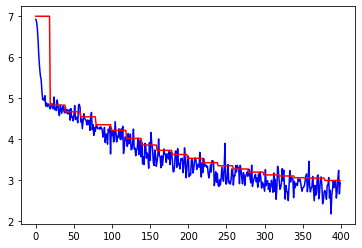

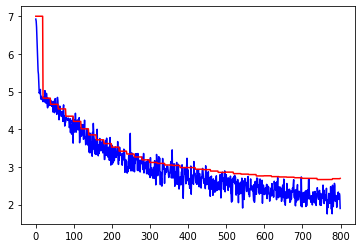

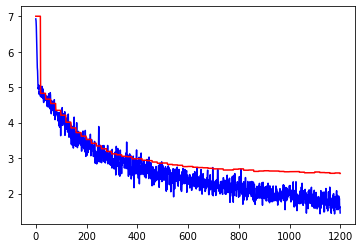

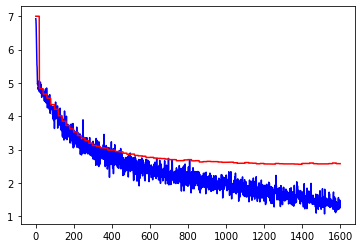

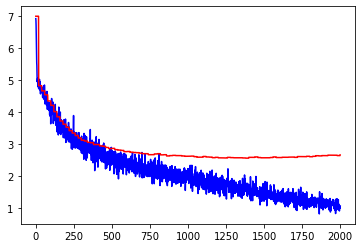

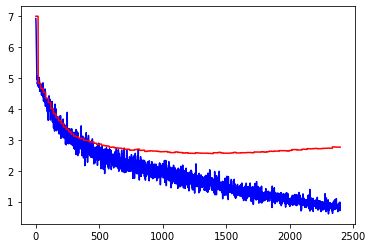

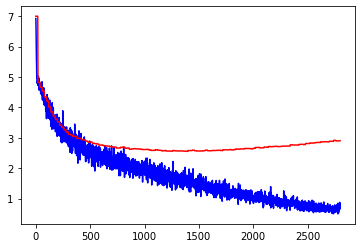

2.556894859969702


hidden dropout attn leaning weight layers batchsize (512, 0.1, 'dot', 0.001, 0.1, 2, 2, 8)
START TRAINING




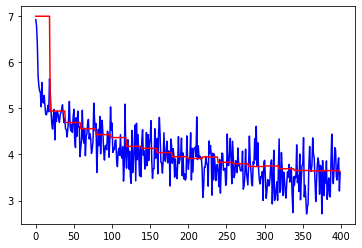

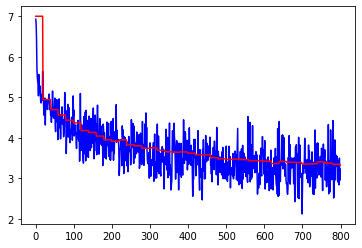

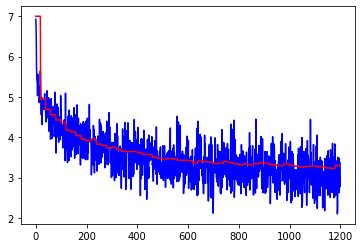

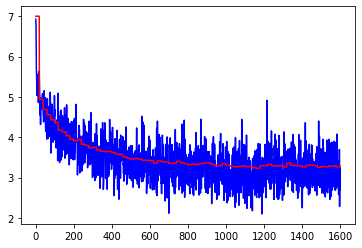

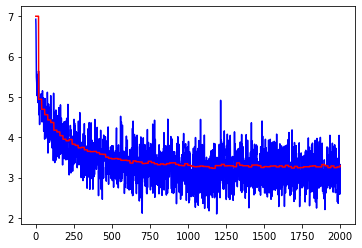

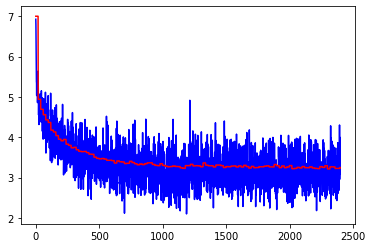

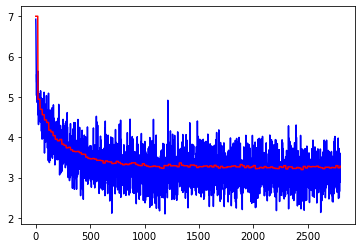

3.199024173190564


hidden dropout attn leaning weight layers batchsize (512, 0.1, 'dot', 0.001, 0.1, 2, 2, 16)
START TRAINING




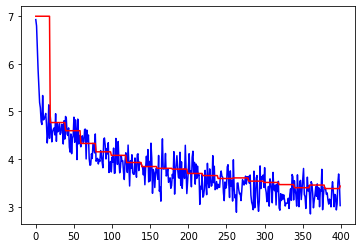

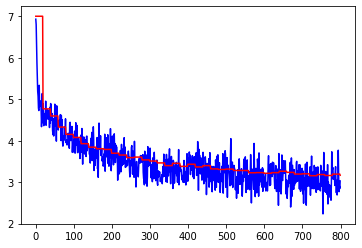

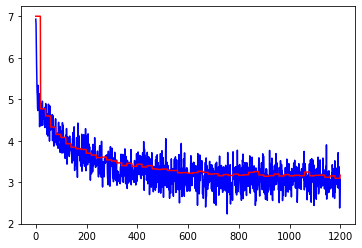

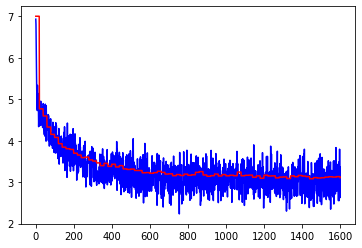

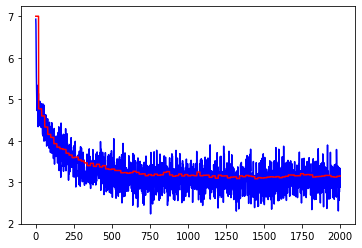

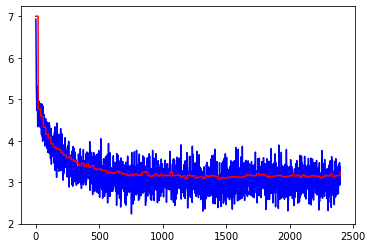

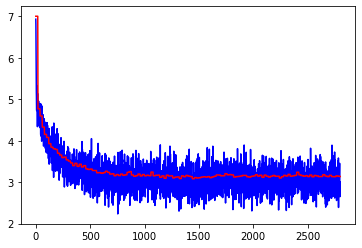

3.082175831374059


hidden dropout attn leaning weight layers batchsize (512, 0.1, 'dot', 0.001, 0.1, 2, 2, 32)
START TRAINING




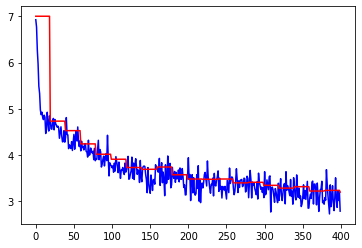

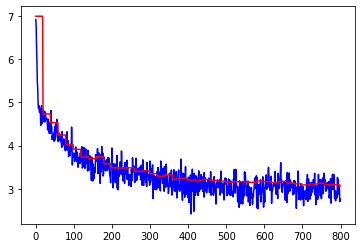

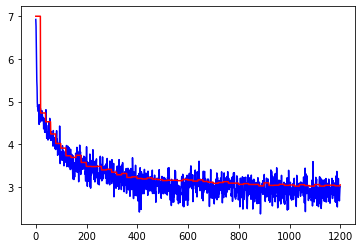

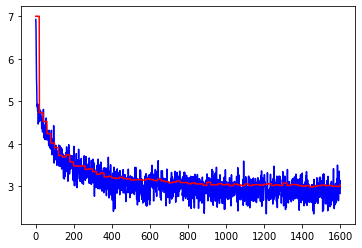

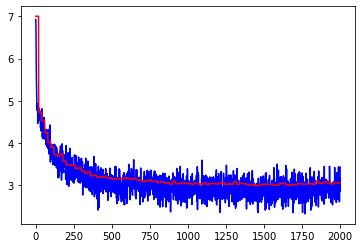

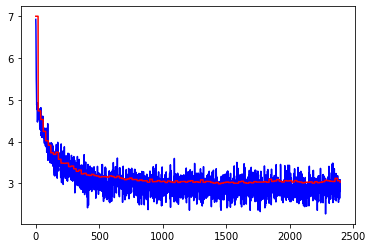

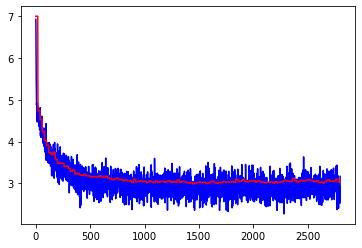

2.989190609194712


hidden dropout attn leaning weight layers batchsize (512, 0.1, 'dot', 0.001, 0.001, 2, 2, 8)
START TRAINING




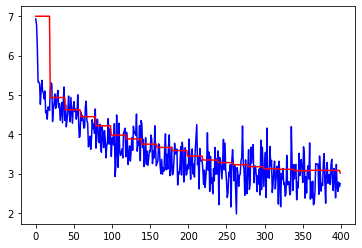

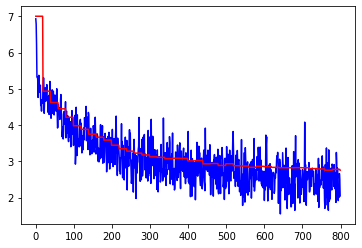

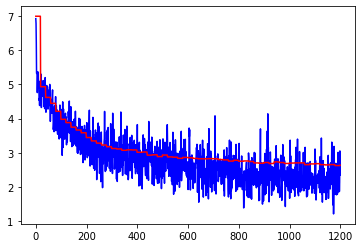

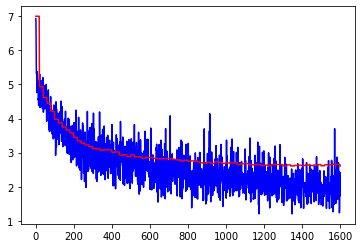

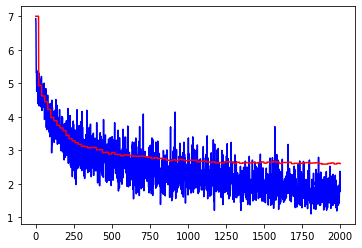

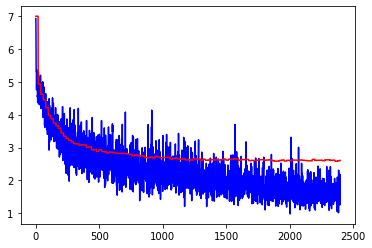

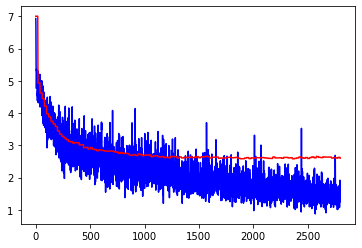

2.582688726683111


hidden dropout attn leaning weight layers batchsize (512, 0.1, 'dot', 0.001, 0.001, 2, 2, 16)
START TRAINING




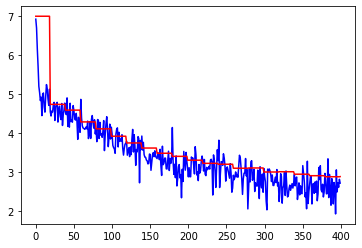

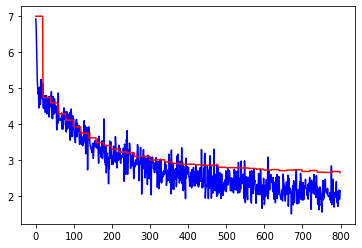

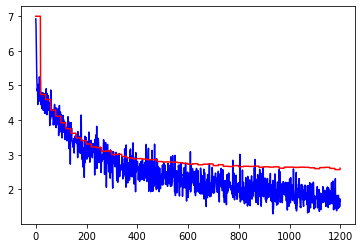

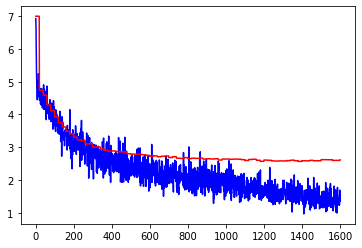

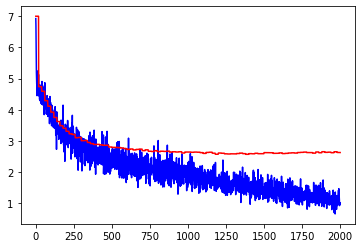

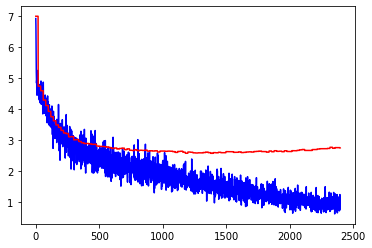

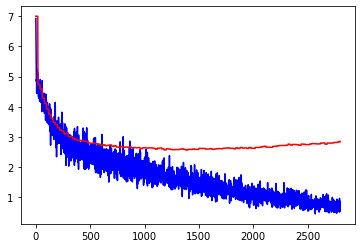

2.5669320549764967


hidden dropout attn leaning weight layers batchsize (512, 0.1, 'dot', 0.001, 0.001, 2, 2, 32)
START TRAINING




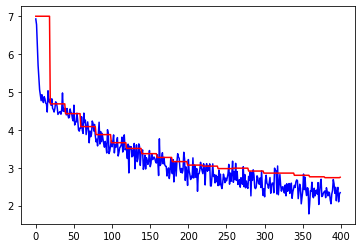

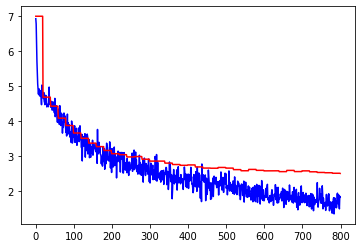

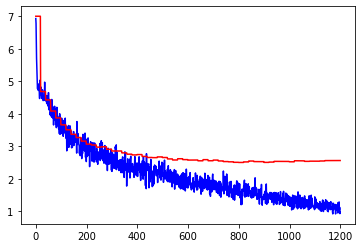

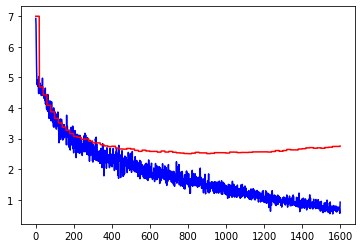

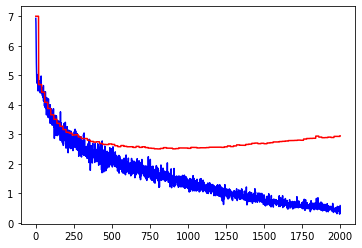

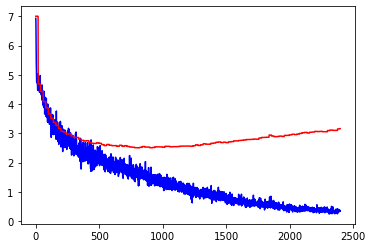

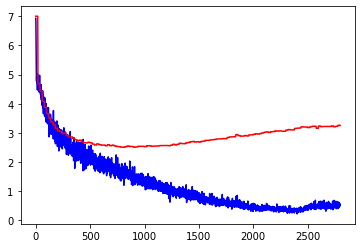

2.505335483344913


best model [(256, 0.1, 'dot', 0.001, 0.001, 2, 2, 16), 2.4463246061314456]


In [32]:
n_iteration = 2800
clip = 50.0

hidden_options = [128, 256, 512]
layer_options = [2]
batch_options = [8, 16, 32]
learnrate_options = [0.001]
dropout_options = [0.1]
weightdecay_options = [0.1,0.001]
attn_models = ['dot']



params = [(h, d, a, l, w, el, dl, b) for h in hidden_options for d in dropout_options 
          for a in attn_models for l in learnrate_options for w in weightdecay_options for el in layer_options for dl in layer_options for b in batch_options]

best_model = [params[0], 100000]
#params, valid_loss

for p in params:
    print("hidden dropout attn leaning weight layers batchsize", p)
    
    hidden_size = p[0]
    dropout = p[1]
    attn_model = p[2]
    LEARN_RATE = p[3]
    WEIGHT_DECAY = p[4]
    encoder_n_layers = p[5]
    decoder_n_layers = p[6]
    small_batch_size = p[7]
    
    valid_loss = trainIters(voc, pairs, hidden_size, dropout, attn_model, LEARN_RATE, WEIGHT_DECAY, encoder_n_layers, decoder_n_layers, n_iteration, small_batch_size, clip, INPUT_SIZE)
    
    print(valid_loss)
    print('\n')
    
    
    if valid_loss < best_model[1]:
        best_model = [p, valid_loss]

print("best model", best_model)


EVALUATION on validation set

In [ ]:
TEST_SIZE = 30

encoder.eval()
decoder.eval()

searcher = GreedySearchDecoder(encoder, decoder)

evaluate_with_target(encoder, decoder, searcher, voc, TEST_SIZE, INPUT_SIZE)